In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
import pandas as pd
from newGraphDiscovery import GraphDiscoveryNew
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from scipy.integrate import solve_ivp

def F(t, X): #all k = 1
    H_2, H, C2H4, C2H5 = X
    u = - H_2 + H**2
    d = 2*H_2 - 2*H**2 - C2H4*H - C2H5*H 
    t = -C2H4*H
    q = C2H4*H - C2H5*H
    return u, d, t, q


def build_dataset(n_init_cond = 50, t_f = 5, n_times_per_cond = 50):
    l = np.zeros((n_init_cond*n_times_per_cond,8))
    for i in range(n_init_cond):
        sol = solve_ivp(F,(0,t_f), np.random.random(size = 4), t_eval = np.linspace(0,t_f,n_times_per_cond))
        derivatives = [F(None, i) for i in sol.y.T]
        l[i*n_times_per_cond:(i+1)*n_times_per_cond] = np.hstack((sol.y.T, derivatives))
    return l

#t_f = 5
#n_times_per_cond = 50
#sol = solve_ivp(F,(0,t_f), onp.random.random(size = 4), t_eval = np.linspace(0,t_f,n_times_per_cond))

l = build_dataset()

In [3]:
X=(l-np.mean(l,axis=0))/np.std(l,axis=0)

# No prior information

In [5]:
names=np.array([
    '$H_2$',
    '$H$',
    '$C_2H_4$',
    '$C_2H_5$',
    '$\partial_tH_2$',
    '$\partial_tH$',
    '$\partial_tC_2H_4$',
    '$\partial_tC_2H_5$'
])
beta=np.array([0.1,0.01,0.001])
graph_discovery=GraphDiscoveryNew(X.T,beta,names,l=1)
for node in graph_discovery.names:
    print(f'inspecting {node}')
    graph_discovery.find_ancestors(node,gamma='auto',kPCA='no')
    print('\n')

Computing kernel matrix
inspecting $H_2$
linear kernel (using gamma=1.09e+02)
 n/(n+s)=0.33, Z=-35.32
decision : accepted
$H_2$ has ancestors with linear kernel (n/(s+n)=0.33)
ancestors : ['$H$', '$C_2H_5$', '$\\partial_tH_2$', '$\\partial_tH$', '$\\partial_tC_2H_4$', '$\\partial_tC_2H_5$']
 n/(n+s)=0.33, Z=-35.32
decision : accepted
ancestors : ['$H$', '$\\partial_tH_2$', '$\\partial_tH$', '$\\partial_tC_2H_4$', '$\\partial_tC_2H_5$']
 n/(n+s)=0.34, Z=-35.32
decision : accepted
ancestors : ['$H$', '$\\partial_tH_2$', '$\\partial_tH$', '$\\partial_tC_2H_4$']
 n/(n+s)=0.35, Z=-35.33
decision : accepted
ancestors : ['$H$', '$\\partial_tH_2$', '$\\partial_tC_2H_4$']
 n/(n+s)=0.36, Z=-35.33
decision : accepted
ancestors : ['$H$', '$\\partial_tH_2$']
 n/(n+s)=0.35, Z=-35.33
decision : accepted
ancestors : ['$H$']
 n/(n+s)=0.71, Z=-35.33
decision : refused
ancestors after pruning:  ['$H$', '$\\partial_tH_2$'] 



inspecting $H$
linear kernel (using gamma=1.12e+02)
 n/(n+s)=0.40, Z=-35.31
dec

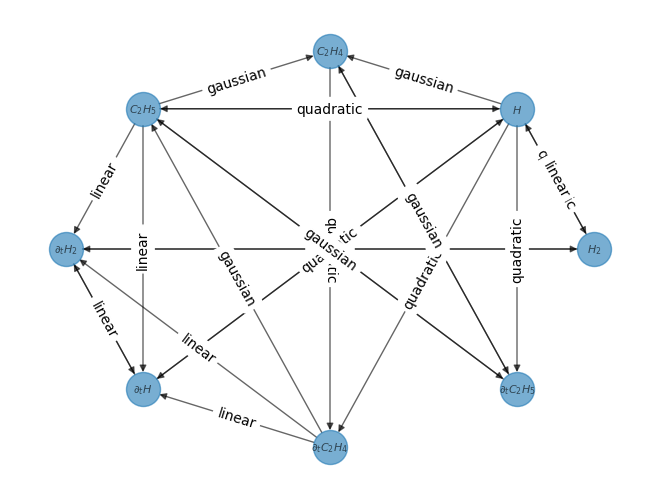

In [6]:
graph_discovery.plot_graph()

In [5]:

def plot_a_network(G,type_label=True):
    pos=nx.kamada_kawai_layout(G, G.nodes())
    nx.draw(G, with_labels=True, pos=pos, node_size=600, font_size=8, alpha=0.6)
    if type_label:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'type'))
    x_values, y_values = zip(*pos.values())
    x_max = max(x_values)
    x_min = min(x_values)
    x_margin = (x_max - x_min) * 0.25
    plt.xlim(x_min - x_margin, x_max + x_margin)

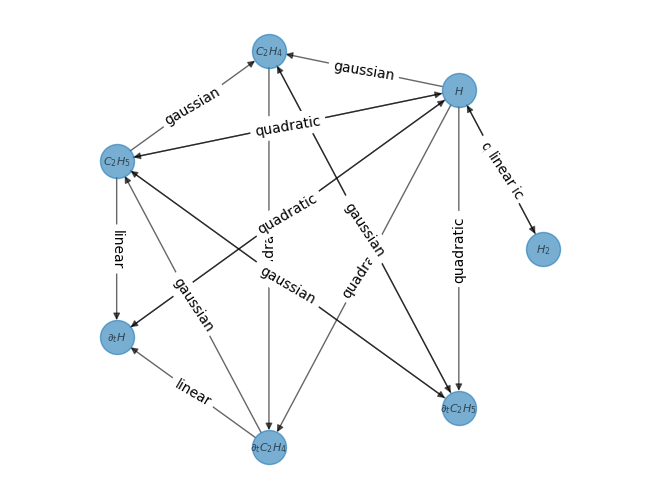

In [9]:
plot_a_network(nx.ego_graph(graph_discovery.G.reverse(),'$C_2H_4$',undirected=False,radius=1).reverse(),type_label=True)

# Using prior information of Bipartite graph

In [17]:
names=np.array([
    '$H_2$',
    '$H$',
    '$C_2H_4$',
    '$C_2H_5$',
    '$\partial_tH_2$',
    '$\partial_tH$',
    '$\partial_tC_2H_4$',
    '$\partial_tC_2H_5$'
])

not_free=np.array([
    '$\partial_tH_2$',
    '$\partial_tH$',
    '$\partial_tC_2H_4$',
    '$\partial_tC_2H_5$'
])
free=np.array([
    '$H_2$',
    '$H$',
    '$C_2H_4$',
    '$C_2H_5$'
])
possible_edges=nx.DiGraph()
for f_node in free:
    for nf_node in not_free:
        possible_edges.add_edge(f_node,nf_node)
        possible_edges.add_edge(nf_node,f_node)

def acceptation_logic(noise,Z,which):
    if noise<0.5:
        return True
    return False

beta=np.array([0.1,0.01,0.001])
graph_discovery=GraphDiscoveryNew(X.T,beta,names,l=1,possible_edges=possible_edges)
for node in not_free:
    print(f'inspecting {node}')
    graph_discovery.find_ancestors(node,gamma='auto',kPCA='no',acceptation_logic=acceptation_logic)
    print('\n')

Computing kernel matrix
inspecting $\partial_tH_2$
linear kernel (using gamma=2.52e+02)
 n/(n+s)=0.85, Z=-35.25
decision : refused
quadratic kernel (using gamma=4.65e+01)
 n/(n+s)=0.52, Z=-35.28
decision : refused
gaussian kernel (using gamma=3.19e-06)
 n/(n+s)=0.00, Z=-33.16
decision : accepted
$\partial_tH_2$ has ancestors with gaussian kernel (n/(s+n)=0.00)
ancestors : ['$H_2$', '$H$', '$C_2H_4$']
 n/(n+s)=0.00, Z=-34.09
decision : accepted
ancestors : ['$H_2$', '$H$']
 n/(n+s)=0.00, Z=-34.94
decision : accepted
ancestors : ['$H_2$']
 n/(n+s)=1.00, Z=-1.21
decision : refused
ancestors after pruning:  ['$H_2$', '$H$'] 



inspecting $\partial_tH$
linear kernel (using gamma=2.52e+02)
 n/(n+s)=0.91, Z=-35.14
decision : refused
quadratic kernel (using gamma=4.65e+01)
 n/(n+s)=0.55, Z=-35.28
decision : refused
gaussian kernel (using gamma=3.19e-06)
 n/(n+s)=0.00, Z=-33.16
decision : accepted
$\partial_tH$ has ancestors with gaussian kernel (n/(s+n)=0.00)
ancestors : ['$H_2$', '$H$', '$C_

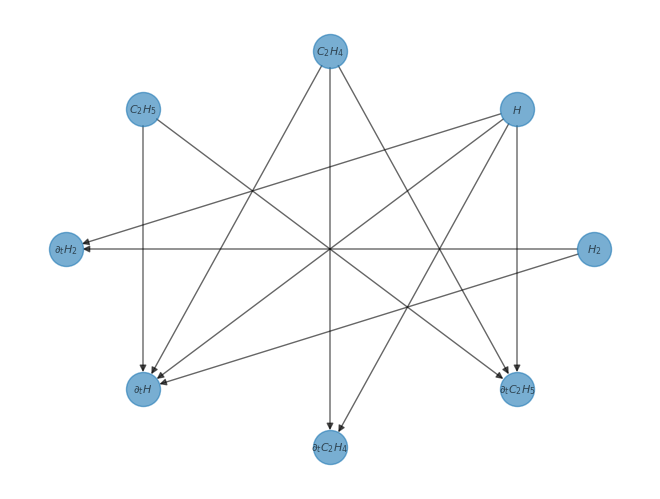

In [19]:
graph_discovery.plot_graph(False)